# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

# Load and normalize data

In [2]:
dataset = pd.read_csv(r'movie_reviews.csv')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# normalize datasets
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# Traditional Supervised Machine Learning Models

## Feature Engineering

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_reviews)
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

In [4]:
# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)

In [5]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (35000, 2114022)  Test features shape: (15000, 2114022)
TFIDF model:> Train features shape: (35000, 2114022)  Test features shape: (15000, 2114022)


## Model Training, Prediction and Performance Evaluation

In [6]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm = SGDClassifier(loss='hinge', n_iter=100)

In [7]:
# Logistic Regression model on BOW features
lr_bow_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.90      0.91      0.91      7510
   negative       0.91      0.90      0.90      7490

avg / total       0.91      0.91      0.91     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6817      693
        negative        731     6759


In [8]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.89      0.90      0.90      7510
   negative       0.90      0.89      0.90      7490

avg / total       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6780      730
        negative        828     6662


In [9]:
svm_bow_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.90      0.89      0.90      7510
   negative       0.90      0.91      0.90      7490

avg / total       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6721      789
        negative        711     6779


In [10]:
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.89      0.91      0.90      7510
   negative       0.91      0.88      0.90      7490

avg / total       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6839      671
        negative        871     6619


# Newer Supervised Deep Learning Models

In [11]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


## Prediction class label encoding

In [12]:
le = LabelEncoder()
num_classes=2 
# tokenize train reviews & encode train labels
tokenized_train = [tn.tokenizer.tokenize(text)
                   for text in norm_train_reviews]
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)
# tokenize test reviews & encode test labels
tokenized_test = [tn.tokenizer.tokenize(text)
                   for text in norm_test_reviews]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [13]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'positive': 1, 'negative': 0}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'positive' 'negative'] 
Encoded Labels: [0 1 0] 
One hot encoded Labels:
 [[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


## Feature Engineering with word embeddings

In [14]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)    

In [15]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [16]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=500)

In [17]:
# feature engineering with GloVe model
train_nlp = [tn.nlp(item) for item in norm_train_reviews]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [tn.nlp(item) for item in norm_test_reviews]
test_glove_features = np.array([item.vector for item in test_nlp])

In [18]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (35000, 500)  Test features shape: (15000, 500)
GloVe model:> Train features shape: (35000, 300)  Test features shape: (15000, 300)


## Modeling with deep neural networks 

### Building Deep neural network architecture

In [19]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [68]:
w2v_dnn = construct_deepnn_architecture(num_input_features=500)

### Visualize sample deep architecture

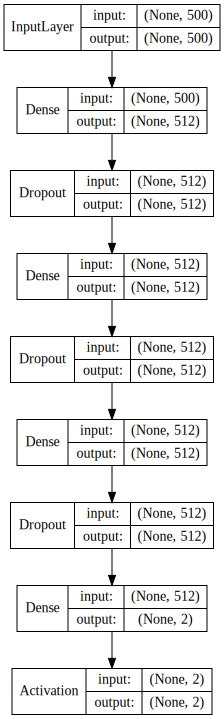

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Model Training, Prediction and Performance Evaluation

In [69]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=5, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 11s - loss: 0.3097 - acc: 0.8720 - val_loss: 0.3159 - val_acc: 0.8646
Epoch 2/5
31500/31500 [==============================] - 11s - loss: 0.2869 - acc: 0.8819 - val_loss: 0.3024 - val_acc: 0.8743
Epoch 3/5
31500/31500 [==============================] - 11s - loss: 0.2778 - acc: 0.8857 - val_loss: 0.3012 - val_acc: 0.8763
Epoch 4/5
31500/31500 [==============================] - 11s - loss: 0.2708 - acc: 0.8901 - val_loss: 0.3041 - val_acc: 0.8734
Epoch 5/5
31500/31500 [==============================] - 11s - loss: 0.2612 - acc: 0.8920 - val_loss: 0.3023 - val_acc: 0.8763


In [70]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

14656/15000 [============================>.] - ETA: 0s

In [71]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.88      0.89      0.88      7510
   negative       0.89      0.87      0.88      7490

avg / total       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6711      799
        negative        952     6538


In [25]:
glove_dnn = construct_deepnn_architecture(num_input_features=300)

In [26]:
batch_size = 100
glove_dnn.fit(train_glove_features, y_train, epochs=5, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 11s - loss: 0.4171 - acc: 0.8096 - val_loss: 0.3686 - val_acc: 0.8397
Epoch 2/5
31500/31500 [==============================] - 10s - loss: 0.3734 - acc: 0.8364 - val_loss: 0.4048 - val_acc: 0.8129
Epoch 3/5
31500/31500 [==============================] - 10s - loss: 0.3657 - acc: 0.8395 - val_loss: 0.3933 - val_acc: 0.8326
Epoch 4/5
31500/31500 [==============================] - 10s - loss: 0.3551 - acc: 0.8450 - val_loss: 0.3555 - val_acc: 0.8403
Epoch 5/5
31500/31500 [==============================] - 11s - loss: 0.3523 - acc: 0.8450 - val_loss: 0.3544 - val_acc: 0.8437


In [27]:
y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred) 

14816/15000 [============================>.] - ETA: 0s

In [28]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.85      0.85      0.85      7510
   negative       0.85      0.85      0.85      7490

avg / total       0.85      0.85      0.85     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6370     1140
        negative       1154     6336
